<a href="https://colab.research.google.com/github/Patisson4/ML/blob/lab-6/lab7p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8192,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform= torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=8192,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [3]:
print(f'train: {len(trainset)}, test: {len(testset)}')

train: 60000, test: 10000


In [4]:
train_unique =  trainset.targets.unique(return_counts=True)[1]
test_unique = testset.targets.unique(return_counts=True)[1]
is_uni_train = (torch.mean(test_unique[0].float()) == test_unique[0]).item()
is_uni_test = (torch.mean(train_unique[0].float()) == train_unique[0]).item()

In [5]:
print(f'Train {"is" if is_uni_train else "is not"} uniform distrubuted')
print(f'Test {"is" if is_uni_test else "is not"} uniform distrubuted')

Train is uniform distrubuted
Test is uniform distrubuted


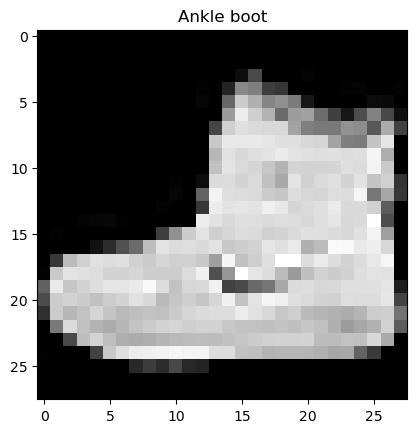

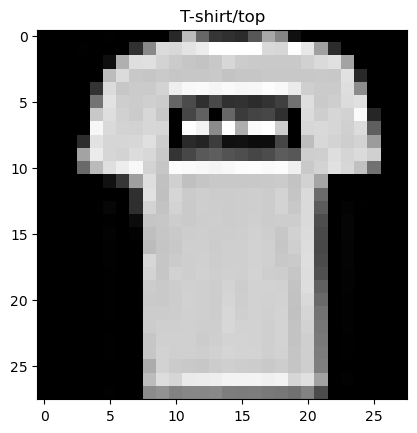

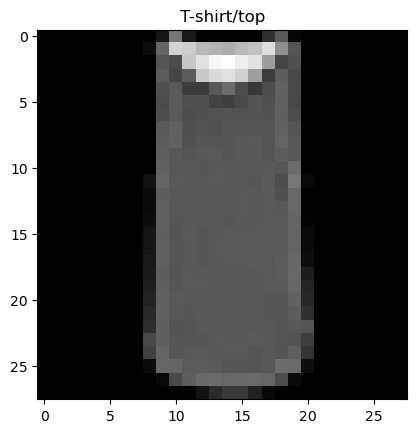

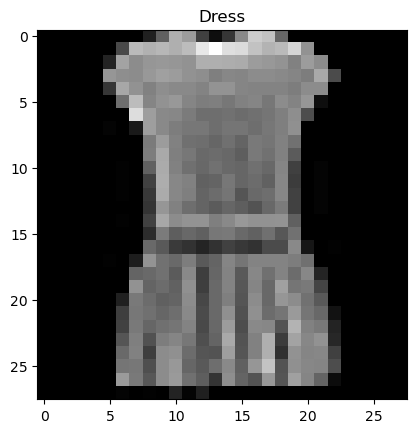

In [6]:
for i in range(4):
    plt.imshow(trainset.data[i], cmap='gray')
    plt.title(classes[trainset.targets[i].item()])
    plt.show()


In [7]:
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchmetrics import Accuracy
from tqdm.auto import trange, tqdm
import sys

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [9]:
def train(model, epochs, optim, loss_fn, trainloader):
    model.train()
    model.to(device)

    loss_arr = []
    acc_arr = []
    metrics = Accuracy('multiclass', num_classes=10).to(device)

    for epoch in tqdm(range(epochs), desc='Epoch', leave=False):

        cnt = 0
        running_acc = 0.0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optim.step()
            running_loss += loss.item()
            running_acc += (outputs.argmax(dim=1) == labels).float().mean().item()
        
        loss_arr.append(running_loss / len(trainloader))
        acc_arr.append(running_acc / len(trainloader))

        if(epoch % 10 == 0):
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_arr[-1]:.4f}, Acc: {acc_arr[-1]:.4f}')
        

    print('Finished Training')
    return model, loss_arr, acc_arr

In [10]:
def test(model, testloader):
    model.eval()
    model.to(device)
    metrics = Accuracy('multiclass', num_classes=10).to(device)
    acc = 0.0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            acc += metrics(outputs, labels)
            total += 1

    print(f'Accuracy on test set is {acc/total:.2f}')

In [11]:
class MLP(nn.Module):
    def __init__(self, in_sz = 28*28, out_sz = 10):
        super(MLP, self).__init__()
        self.in_sz = in_sz
        self.fc1 = nn.Linear(in_sz, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropou2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.dropou3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(128, out_sz)
        
    def predict_proba(self, x):
        pred_y = self.forward(x)
        return F.softmax(pred_y, dim=1)

    def predict(self, x):
        return torch.argmax(self.predict_proba(x), dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropou2(F.relu(self.fc2(x)))
        x = self.dropou3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [12]:
model = MLP()

optim = Adam(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

model, loss, accuracy= train(model, 50, optim, loss_fn, trainloader)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 1.9977, Acc: 0.3049
Epoch 11/50, Loss: 0.4529, Acc: 0.8405
Epoch 21/50, Loss: 0.3480, Acc: 0.8747
Epoch 31/50, Loss: 0.3009, Acc: 0.8912
Epoch 41/50, Loss: 0.2640, Acc: 0.9033
Finished Training


Accuracy on test set is 0.89


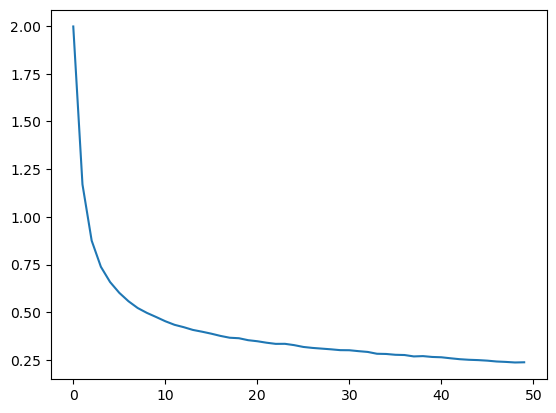

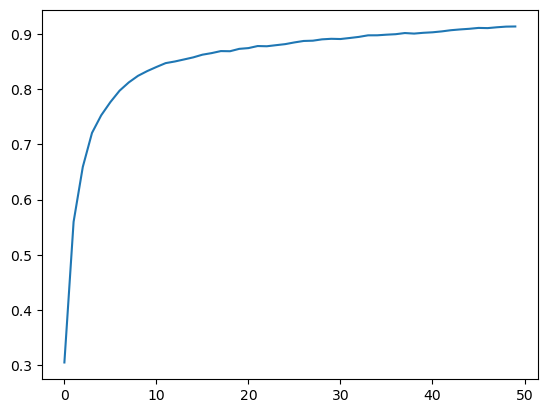

In [13]:
test(model, testloader)

plt.plot(loss)
plt.show()

plt.plot(accuracy)
plt.show()

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1600, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def predict_proba(self, x):
        pred_y = self.forward(x)
        return F.softmax(pred_y, dim=1)

    def predict(self, x):
        return torch.argmax(self.predict_proba(x), dim=1)

    def forward(self, x):
        x = self.maxpool1(F.relu(self.conv1(x)))
        x = self.maxpool2(F.relu(self.conv2(x)))
        x = x.view(-1, 1600)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [15]:
model = CNN()

optim = Adam(params=model.parameters())
loss_fn = nn.CrossEntropyLoss()

model, loss, accuracy= train(model, 50, optim, loss_fn, trainloader)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 2.1095, Acc: 0.3911
Epoch 11/50, Loss: 0.5265, Acc: 0.8019
Epoch 21/50, Loss: 0.4017, Acc: 0.8572
Epoch 31/50, Loss: 0.3402, Acc: 0.8786
Epoch 41/50, Loss: 0.3063, Acc: 0.8882
Finished Training


Accuracy on test set is 0.89


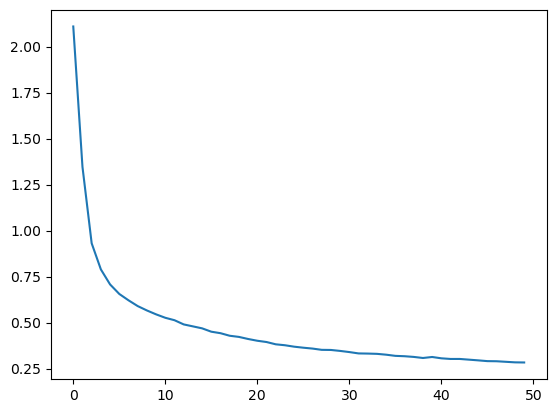

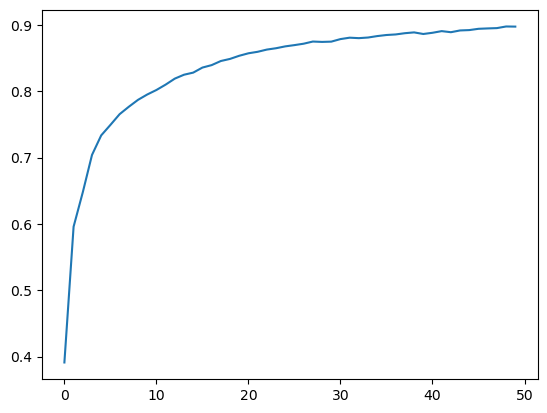

In [16]:

test(model, testloader)

plt.plot(loss)
plt.show()

plt.plot(accuracy)
plt.show()

### Вывод

Точности одинаковы у обеих моделей. Графики и значения loss тоже примерно равны.